# Approach 3: Data forecasting with ARIMA model

In this notebook we are going to try to forecast the player's OBP using an ARIMA model. Due to the time it takes to train each model, we will not be able to complete the training for all players but instead will only look at a few example players to show the approach. 


In [1]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255);
blue_cb = np.divide((0, 114, 178),255);
green   = np.divide((0, 158, 115),255);
pink    = np.divide((204, 121, 167),255);


## Load data

In [2]:
# Load statcast data or download directly. NOTE: THIS TAKES A WHILE TO GET ALL DATA
load_statcast_data = True

In [3]:
def add_mlb_id(temp,_players):
    temp["key_mlbam"] = _players.loc[_players.key_fangraphs.isin([temp.playerid]),"key_mlbam"].item()
    return temp

# Load data as bd -> short for batting data
bd = pd.read_csv("./data/batting.csv")

# Convert and % str to float
cols = [col for col in bd.columns if '%' in col] + ["MarApr_HR/FB"]
for col in cols:
    bd[col] = bd[col].str.rstrip('%').astype('float') / 100.0

# Get data for matching IDs    
_players = pybaseball.playerid_reverse_lookup(bd.playerid.tolist(),key_type='fangraphs')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Get MLB id
bd = bd.apply(lambda temp: add_mlb_id(temp,_players),axis=1)
bd.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP,key_mlbam
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.057,0.400,0.226,0.660,0.407,0.811,0.884,0.860,0.406,641355
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.118,0.412,0.279,0.724,0.448,0.566,0.878,0.757,0.429,592885
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.000,0.222,0.402,0.745,0.535,0.543,0.854,0.711,0.315,664068
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.000,0.200,0.273,0.505,0.373,0.939,0.978,0.962,0.353,519299
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.074,0.296,0.237,0.488,0.337,0.661,0.827,0.757,0.341,596129


We need to get all relevant data from each game in order to calculate cumulative metrics.

In [4]:
# Add data to dataframe
def get_statcast_data(temp,start_dt='2015-04-05', end_dt='2019-11-30'):

    # Get player data
    data = pybaseball.statcast_batter(start_dt=start_dt, end_dt=end_dt,player_id=temp.key_mlbam)
    
    # Keep only regular season data
    data = data.loc[data.game_type.isin(["R"]),:]

    # group by date
    grouped = data.groupby(by="game_date")
    
    # Create empty dataframe
    out = pd.DataFrame()
    for name, group in grouped:
        # Create empty dataframe
        temp = pd.DataFrame()

        # Get name
        temp["player_name"] = [group.player_name.unique()[0]]

        # Get batter MLB ID
        temp["batter"] = [group.batter.unique()[0]]

        # Save date
        temp["game_date"] = [name]
        temp["year"]      = [pd.to_datetime(group.game_date.unique()[0]).year]

        # Some more advanced metrics
        temp["launch_angle"]  = [group.launch_angle.mean(skipna=True)]
        temp["launch_speed"]  = [group.launch_speed.mean(skipna=True)]
        temp["release_speed"] = [group.release_speed.mean(skipna=True)]
        temp["xBA"]           = [group.estimated_ba_using_speedangle.mean(skipna=True)]
        temp["xwOBA"]         = [group.estimated_woba_using_speedangle.mean(skipna=True)]
        temp["wOBA"]          = [group.woba_value.mean(skipna=True)]
        temp["BABIP"]         = [group.babip_value.mean(skipna=True)]
        temp["ISO"]           = [group.iso_value.mean(skipna=True)]

        # Get counts
        counts = group.events.value_counts()

        # Get values for computing OBP
        which_events = ["single","double","triple","home_run","walk","hit_by_pitch","sac_fly","strikeout","field_out","field_error"]#,"grounded_into_double_play","force_out"]
        event_names  = ["B1","B2","B3","HR","BB","HBP","SF","K","FieldOut","FieldErr"]#,"GIDP",,"ForceOut"]
        for (event,event_name) in zip(which_events,event_names):
            temp[event_name]  = counts[event].item() if event in counts else 0

        # Compute new OBP
        temp["H"]   = temp.B1 + temp.B2 + temp.B3 + temp.HR
        temp["AB"]  = temp.H +  temp.K + temp.FieldOut + temp.FieldErr# +temp.GIDP + temp.ForceOut
        temp["OB"]  = (temp.H + temp.BB + temp.HBP)
        temp["TA"]  = (temp.AB + temp.BB + temp.HBP + temp.SF)
        temp["OBP"] = (temp.OB / temp.TA) if (temp.TA > 0).bool() else 0

        # Concatenate to outer dataframe
        out  = pd.concat([out,temp],axis=0)
    return out

#######################################
#                                     #
#        LOAD/DOWNLOAD STATCAST       #
#       (very slow to download!)      #
#                                     #
#######################################
if not load_statcast_data:
    sd = pd.DataFrame() # <--- sd: statcast data
    for row in bd.itertuples():
        temp = get_statcast_data(row)
        sd = pd.concat([sd,temp])

    # Reset index
    sd = sd.reset_index()

    # Save dataframe
    sd.to_pickle("./data/forecasting_data_2015-2019.pkl")
else:
    sd = pd.read_pickle("./data/forecasting_data_2015-2019.pkl")

sd


,index,player_name,batter,game_date,year,launch_angle,launch_speed,release_speed,xBA,xwOBA,...,HBP,SF,K,FieldOut,FieldErr,H,AB,OB,TA,OBP
0,0,"Bellinger, Cody",641355,2017-04-25,2017,16.250000,76.000000,86.725000,0.268667,0.247000,...,0,0,0,2,0,1,3,1,3,0.333333
1,0,"Bellinger, Cody",641355,2017-04-26,2017,63.285714,80.914286,88.581481,0.090000,0.108000,...,0,0,3,2,0,0,5,0,5,0.000000
2,0,"Bellinger, Cody",641355,2017-04-27,2017,55.333333,67.133333,90.427778,NaN,NaN,...,0,0,2,0,0,0,2,1,3,0.333333
3,0,"Bellinger, Cody",641355,2017-04-28,2017,2.750000,66.475000,85.346667,0.313333,0.285333,...,0,0,0,1,0,2,3,3,4,0.750000
4,0,"Bellinger, Cody",641355,2017-04-29,2017,20.200000,96.180000,91.423077,0.608250,1.039000,...,0,0,0,2,0,2,4,2,4,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143893,0,"Allen, Greg",656185,2019-09-25,2019,NaN,NaN,96.600000,NaN,NaN,...,0,0,1,0,0,0,1,0,1,0.000000
143894,0,"Allen, Greg",656185,2019-09-26,2019,15.500000,70.975000,83.592308,0.391333,0.352000,...,0,0,0,1,1,1,3,1,3,0.333333
143895,0,"Allen, Greg",656185,2019-09-27,2019,8.666667,82.933333,88.187500,0.553333,0.510000,...,0,0,0,2,0,1,3,1,3,0.333333
143896,0,"Allen, Greg",656185,2019-09-28,2019,NaN,NaN,85.740000,NaN,NaN,...,0,0,0,0,0,0,0,1,1,1.000000


In [5]:
# Get rolling OBP on a seasonal and career basis
sd = sd.groupby(by=["batter","year"]).apply(lambda gdf: gdf.assign(OBP_expanding_year=lambda gdf: gdf['OBP'].expanding().mean()))#.droplevel()
sd = sd.groupby(by=["batter"]).apply(lambda gdf: gdf.assign(OBP_expanding_career=lambda gdf: gdf['OBP'].expanding().mean()))#.droplevel()

In [279]:
# Useful dicts/lists that will be needed throughout.
mlb_dates = pd.DataFrame({"Year" : [2015, 2016, 2017, 2018, 2019],
                          "Start": pd.to_datetime(['2015-04-05','2016-04-03','2017-04-02','2018-03-29','2019-04-20']),
                          "End"  : pd.to_datetime(['2015-11-01','2016-10-02','2017-11-01','2018-10-28','2019-09-29'])}).set_index("Year")

# Select 10 random players to view - make sure there are no nans in the names
which_players = bd.loc[bd.Team.isin(["PHI"]),"key_mlbam"]#_players.sample(10).key_mlbam.to_numpy()
# while _players.loc[_players.key_mlbam.isin(which_players),["name_last","name_first"]].isna().any().any():
#     which_players = _players.sample(10).key_mlbam.to_numpy()

Lets see what each player's season OBP and career OBP look like. We will compute a cumulative OBP across the player's entire career as well as one that resets every season.

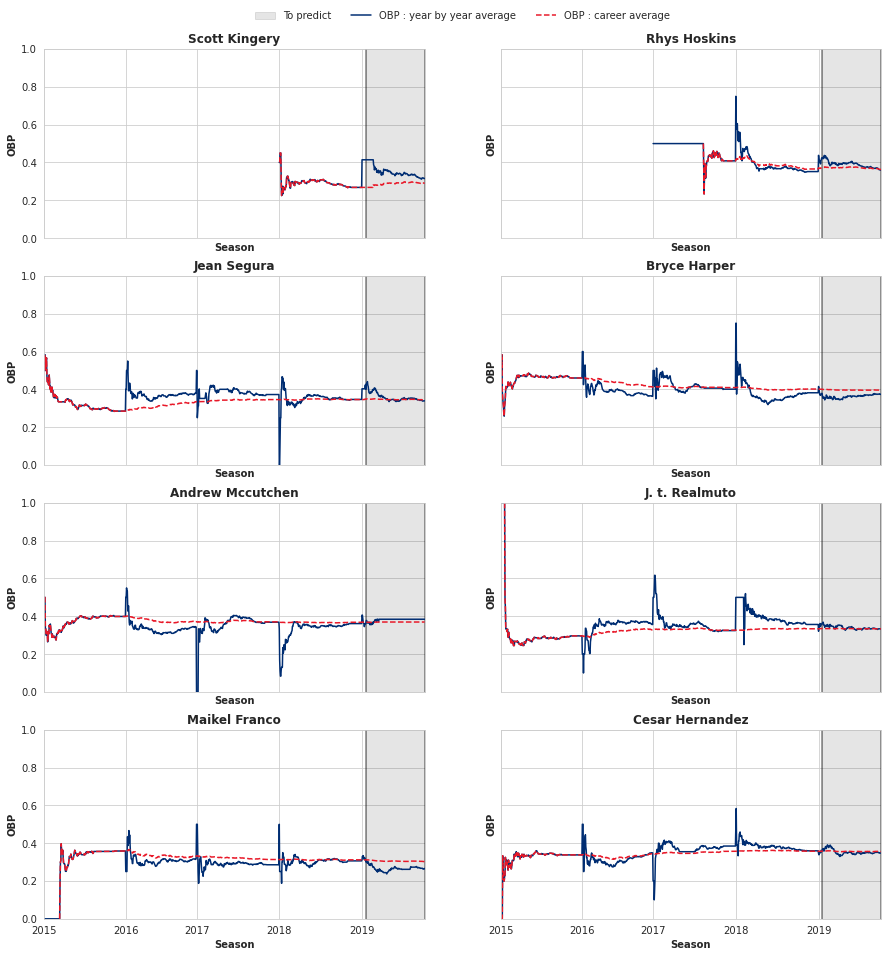

In [281]:
# Season start dates
start_dates = ['2015-04-05','2016-04-03','2017-04-02','2018-03-29','2019-04-20','2019-09-29']

# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(4,2,sharex=True,sharey=True)
    ax = ax.flatten()
    fig.set_size_inches(15,16)

    # For each player
    for (this_player,thisax) in zip(which_players,ax):
        
        # pre allocate
        _local = pd.DataFrame()
        # for each year - even if player did not play that year
        for year in mlb_dates.index:
            # Get data for batter and year and set the game date as the index
            temp = sd.loc[(sd.batter==this_player) & (sd.year == year),:].set_index("game_date")
            # Convert to date time
            temp.index = pd.DatetimeIndex(temp.index)
            # Add all dates during season -- this will add nans where no date curently exists
            temp = temp.reindex(pd.date_range(mlb_dates.loc[year,"Start"],mlb_dates.loc[year,"End"]))
            # Add the batter ID across all time
            temp.loc[:,"batter"]  = temp.loc[:,"batter"].fillna(this_player).astype(int)
            # Fill OBP by first filling from back value (i.e., moving --->) then do a backward pass and forward fill (i.e., <----)
            temp.loc[:,"OBP_expanding_year"] = temp.loc[:,"OBP_expanding_year"].ffill().bfill()
            # Add to outer df
            _local = pd.concat([_local.loc[:,_local.columns != "index"],temp],axis=0)
            # end (for year):

        # Get name and re-add to dataframe as first + last
        name_last, name_first = _players.loc[_players.key_mlbam.isin([this_player]),"name_last"], _players.loc[_players.key_mlbam.isin([this_player]),"name_first"]
        _local.loc[:,"player_name"] = name_first.item().capitalize() + " " + name_last.item().capitalize()
        # Fill career OBP using last value
        _local.loc[:,"OBP_expanding_career"] = _local.loc[:,"OBP_expanding_career"].ffill()
        # Since plotting using game_date will create gaps between seasons, we move that to new column and reset the index as a standard index
        _local = _local.rename_axis('game_date').reset_index()
        # Get the index location of the start game dates
        xticks = _local.loc[_local.game_date.isin(mlb_dates.Start)].index
        # Get index location of data window
        fill_win = _local.loc[_local.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
        
        # Plot data - cumulative OBP year by year and career
        thisax.axvline(x=fill_win[0],color='k',alpha=0.5)
        thisax.axvline(x=fill_win[-1],color='k',alpha=0.5)
        thisax.fill_between(x=fill_win,y1=len(fill_win)*[0],y2=len(fill_win)*[1],color='k',alpha=0.1,label="To predict")
        thisax.plot(_local.index,_local.OBP_expanding_year,color=blue,lw=1.5, label="OBP : year by year average")
        thisax.plot(_local.index,_local.OBP_expanding_career,color=red,linestyle='--',lw=1.5,label="OBP : career average")
        
        # Clean up
        thisax.set_ylim(0,1)
        thisax.set_xlim(_local.loc[_local.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
        thisax.set_xticks(xticks)
        thisax.set_xticklabels(list(map(str,mlb_dates.index)))
        thisax.set_xlabel("Season",fontweight="bold")
        thisax.set_ylabel("OBP",fontweight="bold")
        thisax.set_title(_local.player_name.unique()[0],fontweight="bold")
    
    ax[0].legend(ncol=3,loc=9,frameon=False,bbox_to_anchor=(1.1, 1.25))

Out of curiousity, lets see what their shrunken estimate looks like relative to the year x year and career averages.  First we need to make some functions to get their cumulative OB and TA up until 2015 if they played before then. Otherwise we just start our EB estimate at the beginning of their post-2015 career. Then we will apply our EB estimate to both the year by year data and career data. 

In [282]:
# Get data from baseball reference
def get_previous_OBP(this_guy,year=2015):
    # Get url for player
    url    = "https://www.baseball-reference.com/players/{}/{}.shtml#batting_standard".format(this_guy.key_bbref.item()[0],this_guy.key_bbref.item())
    # Read table from url
    table = pd.read_html(url)[0]
    # Remove nan rows
    table.dropna(subset=['Tm'],inplace=True)
    # Remove minor league stats
    table = table.loc[~table['Tm'].str.contains('-min'),:].reset_index(drop=True)
    # Get stats
    table = table.loc[table['Year'].isin(list(map(str,list(range(int(table.Year[0]),year+1))))),:]

    OB = (table.H.astype(int).sum() + table.BB.astype(int).sum() + table.HBP.astype(int).sum())
    TA = (table.AB.astype(int).sum() + table.BB.astype(int).sum() + table.HBP.astype(int).sum() + table.SF.astype(int).sum())

    return OB, TA
    

# Get all pitcher data
from pybaseball.lahman import pitching
pitching_data = pitching()
_pitcher = pybaseball.playerid_reverse_lookup(pitching_data.playerID.unique().tolist(),key_type='bbref')

# Get alpha, beta if pitcher or not
def get_params(this_player):
    # Determine if pitcher
    if len(_pitcher.loc[_pitcher.key_mlbam.isin([this_player]),:]):
        fl = './data/OBP_EB_params_pitcher.npy'
    else:
        fl = './data/OBP_EB_params_nonpitcher.npy'

    # load file
    with open(fl, 'rb') as f:
            alpha, beta = np.load(f)
    return alpha, beta

# Add data to dataframe
def eb_estimate_obp_simulated(row,alpha,beta,OB_key, TA_key):
    return (row[OB_key] + alpha) / (row[TA_key] + alpha + beta)

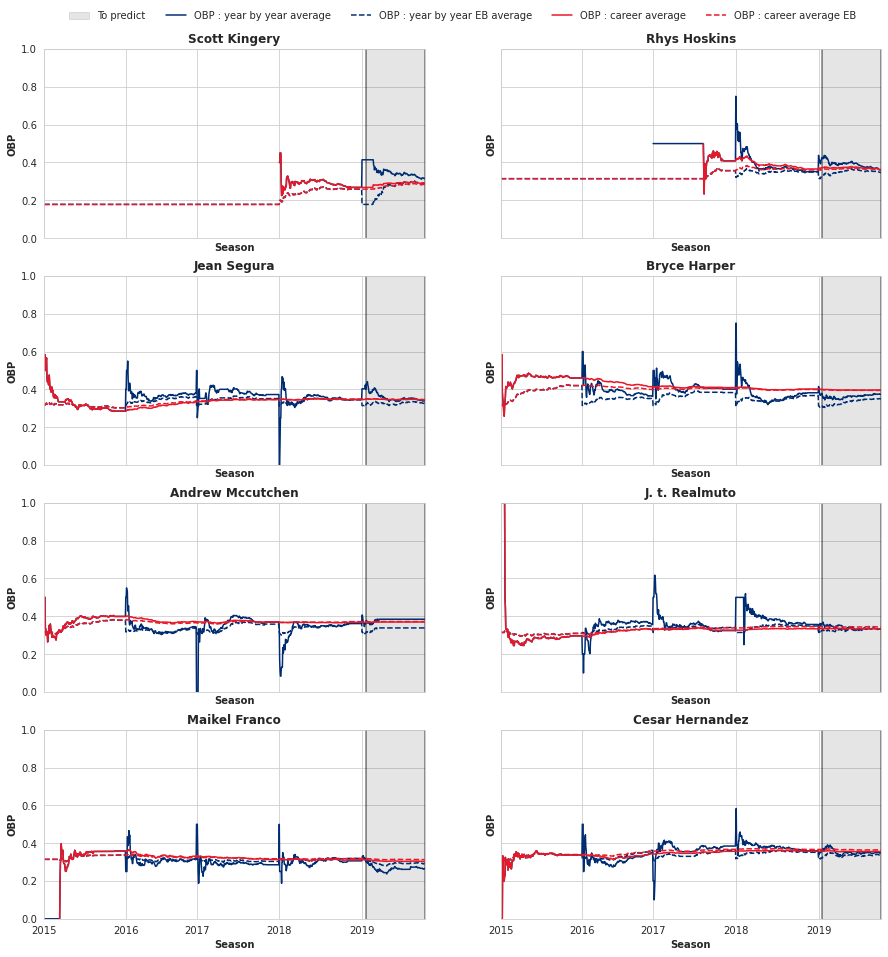

In [284]:
# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(4,2,sharex=True,sharey=True)
    ax = ax.flatten()
    fig.set_size_inches(15,16)

    # For each player
    for (this_player,thisax) in zip(which_players,ax):
        
        # Get previous data
        this_guy = _players.loc[_players.key_mlbam.isin([this_player]),:]
        if (this_guy.mlb_played_first < 2015).bool():
            OB, TA = get_previous_OBP(this_guy)
        
        # Get prior (alpha, beta)
        alpha, beta = get_params(this_player)

        # pre allocate
        _local = pd.DataFrame()
        # for each year - even if player did not play that year
        for year in mlb_dates.index:
            # Get data for batter and year and set the game date as the index
            temp = sd.loc[(sd.batter==this_player) & (sd.year == year),:].set_index("game_date")
            # Convert to date time
            temp.index = pd.DatetimeIndex(temp.index)
            # Add all dates during season -- this will add nans where no date curently exists
            temp = temp.reindex(pd.date_range(mlb_dates.loc[year,"Start"],mlb_dates.loc[year,"End"]))
            # Add the batter ID across all time
            temp.loc[:,"batter"]  = temp.loc[:,"batter"].fillna(this_player).astype(int)
            # Fill OBP by first filling from back value (i.e., moving --->) then do a backward pass and forward fill (i.e., <----)
            temp.loc[:,"OBP_expanding_year"] = temp.loc[:,"OBP_expanding_year"].ffill().bfill()
            temp.loc[:,"OB_cumulative"] = temp.loc[:,"OB"].fillna(0).cumsum()
            temp.loc[:,"TA_cumulative"] = temp.loc[:,"TA"].fillna(0).cumsum()
            # EB estimate on year over year average
            temp.loc[:,"OBP_expanding_year_EB"] = temp.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative","TA_cumulative"),axis=1)
            # Add to outer df
            _local = pd.concat([_local.loc[:,_local.columns != "index"],temp],axis=0)
            # end (for year):

        # Get name and re-add to dataframe as first + last
        name_last, name_first = _players.loc[_players.key_mlbam.isin([this_player]),"name_last"], _players.loc[_players.key_mlbam.isin([this_player]),"name_first"]
        _local.loc[:,"player_name"] = name_first.item().capitalize() + " " + name_last.item().capitalize()
        # Fill career OBP using last value
        _local.loc[:,"OBP_expanding_career"] = _local.loc[:,"OBP_expanding_career"].ffill()
        _local.loc[:,"OB_cumulative_career"] = _local.loc[:,"OB"].fillna(0).cumsum()
        _local.loc[:,"TA_cumulative_career"] = _local.loc[:,"TA"].fillna(0).cumsum()
        # EB estimate on year over year average
        _local.loc[:,"OBP_expanding_career_EB"] = _local.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative_career","TA_cumulative_career"),axis=1)

        # Since plotting using game_date will create gaps between seasons, we move that to new column and reset the index as a standard index
        _local = _local.rename_axis('game_date').reset_index()
        # Get the index location of the start game dates
        xticks = _local.loc[_local.game_date.isin(mlb_dates.Start)].index
        # Get index location of data window
        fill_win = _local.loc[_local.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
        
        # Plot data - cumulative OBP year by year and career
        thisax.axvline(x=fill_win[0],color='k',alpha=0.5)
        thisax.axvline(x=fill_win[-1],color='k',alpha=0.5)
        thisax.fill_between(x=fill_win,y1=len(fill_win)*[0],y2=len(fill_win)*[1],color='k',alpha=0.1,label="To predict")
        thisax.plot(_local.index,_local.OBP_expanding_year,color=blue,lw=1.5, label="OBP : year by year average")
        thisax.plot(_local.index,_local.OBP_expanding_year_EB,color=blue,linestyle='--',lw=1.5,label="OBP : year by year EB average")
        thisax.plot(_local.index,_local.OBP_expanding_career,color=red,lw=1.5,label="OBP : career average")
        thisax.plot(_local.index,_local.OBP_expanding_career_EB,color=red,linestyle='--',lw=1.5,label="OBP : career average EB")
        
        # Clean up
        thisax.set_ylim(0,1)
        thisax.set_xlim(_local.loc[_local.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
        thisax.set_xticks(xticks)
        thisax.set_xticklabels(list(map(str,mlb_dates.index)))
        thisax.set_xlabel("Season",fontweight="bold")
        thisax.set_ylabel("OBP",fontweight="bold")
        thisax.set_title(_local.player_name.unique()[0],fontweight="bold")
    
    ax[0].legend(ncol=5,loc=9,frameon=False,bbox_to_anchor=(1.1, 1.25))

Now we need to apply this to every player so we can use for forecasting. This way of looping through is not the fastest way but it works...

In [285]:
# Empty dataframe for all data
sd2 = pd.DataFrame()

# For each player
for this_player in sd.batter.unique().tolist():
    
    # Get previous data
    this_guy = _players.loc[_players.key_mlbam.isin([this_player]),:]
    if (this_guy.mlb_played_first < 2015).bool():
        OB, TA = get_previous_OBP(this_guy)
    
    # Get prior (alpha, beta)
    alpha, beta = get_params(this_player)

    # pre allocate
    _local = pd.DataFrame()
    # for each year - even if player did not play that year
    for year in mlb_dates.index:
        # Get data for batter and year and set the game date as the index
        temp = sd.loc[(sd.batter==this_player) & (sd.year == year),:].set_index("game_date")
        # Convert to date time
        temp.index = pd.DatetimeIndex(temp.index)
        # Add all dates during season -- this will add nans where no date curently exists
        temp = temp.reindex(pd.date_range(mlb_dates.loc[year,"Start"],mlb_dates.loc[year,"End"]))
        # Add the batter ID across all time
        temp.loc[:,"batter"]  = temp.loc[:,"batter"].fillna(this_player).astype(int)
        # Fill OBP by first filling from back value (i.e., moving --->) then do a backward pass and forward fill (i.e., <----)
        temp.loc[:,"OBP_expanding_year"] = temp.loc[:,"OBP_expanding_year"].ffill().bfill()
        temp.loc[:,"OB_cumulative"] = temp.loc[:,"OB"].fillna(0).cumsum()
        temp.loc[:,"TA_cumulative"] = temp.loc[:,"TA"].fillna(0).cumsum()
        # EB estimate on year over year average
        temp.loc[:,"OBP_expanding_year_EB"] = temp.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative","TA_cumulative"),axis=1)
        # Add to outer df
        _local = pd.concat([_local.loc[:,_local.columns != "index"],temp],axis=0)
        # end (for year):

    # Get name and re-add to dataframe as first + last
    name_last, name_first = _players.loc[_players.key_mlbam.isin([this_player]),"name_last"], _players.loc[_players.key_mlbam.isin([this_player]),"name_first"]
    _local.loc[:,"player_name"] = name_first.item().capitalize() + " " + name_last.item().capitalize()
    
    # Fill career OBP using last value
    _local.loc[:,"OBP_expanding_career"] = _local.loc[:,"OBP_expanding_career"].ffill()
    _local.loc[:,"OB_cumulative_career"] = _local.loc[:,"OB"].fillna(0).cumsum()
    _local.loc[:,"TA_cumulative_career"] = _local.loc[:,"TA"].fillna(0).cumsum()
    # EB estimate on year over year average
    _local.loc[:,"OBP_expanding_career_EB"] = _local.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative_career","TA_cumulative_career"),axis=1)

    # Move game date to new column and reset the index as a standard index
    _local = _local.rename_axis('game_date').reset_index()

    # Add to outer dataframe
    sd2 = pd.concat([sd2,_local])

# Reset index
sd2 = sd2.reset_index(drop=True)


## Forecasting using an ARIMA model

We will start with an Auto-Regressive Integrated Moving Average model on a single player and check out the residuals. 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3076.313
Date:                Thu, 21 Jul 2022   AIC                          -6140.625
Time:                        16:50:29   BIC                          -6112.282
Sample:                             0   HQIC                         -6129.757
                                - 833                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1566      0.012    -12.572      0.000      -0.181      -0.132
ar.L2         -0.1061      0.012     -8.987      0.000      -0.129      -0.083
ar.L3          0.0305      0.006      4.979      0.0

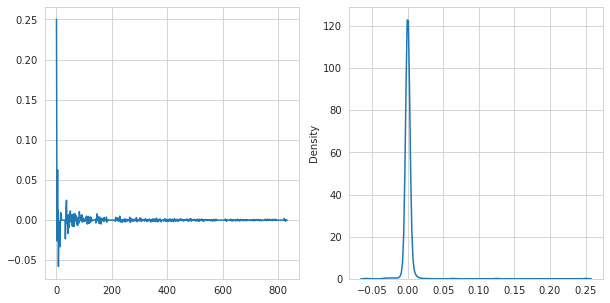

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Get player data
player_data = sd2.loc[sd2.player_name.isin(["Christian Yelich"]),:].reset_index(drop=True)

# Get training data
mask = (player_data.game_date < "2019-05-01")
train = player_data.loc[mask,"OBP_expanding_career"].to_numpy()
test  = player_data.loc[~mask,"OBP_expanding_career"].to_numpy()

# Fit model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# summary stats of residuals
print(pd.DataFrame(model_fit.resid).describe())
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)

    # line plot of residuals
    ax[0].plot(model_fit.resid)

    # density plot of residuals
    sns.kdeplot(model_fit.resid,ax=ax[1])


Now lets see what this looks like on two players.

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3894.094, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4147.073, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3901.293, Time=0.07 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-4242.980, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-4239.655, Time=0.71 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4331.134, Time=1.30 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-4231.485, Time=0.99 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.65 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4330.811, Time=1.58 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4332.597, Time=2.79 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-4227.488, Time=0.70 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=4.80 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=2.32 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4322.679, Time=1.96 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4329.822, Time=2.76 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-4355.041, Time=3.23 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=inf, Time=7.20 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-4346.900, Time=2.62 sec
 ARIMA(3,1,2)(2,1,0)[12]             : AIC=-4341.521, Time=2.41 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(2,1,0)[12]             : AIC=-4338.500, Time=2.99 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(2,1,0)[12]             : AIC=-4346.820, Time=2.64 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,3)(2,1,0)[12]             : AIC=-4348.675, Time=2.89 sec
 ARIMA(2,1,2)(2,1,0)[12] intercept   : AIC=-4332.770, Time=1.91 sec

Best model:  ARIMA(2,1,2)(2,1,0)[12]          
Total fit time: 65.512 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-5361.078, Time=4.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4987.420, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-5273.949, Time=2.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-5341.802, Time=1.89 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-5282.599, Time=1.39 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-5294.605, Time=3.58 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-5329.522, Time=4.27 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-5286.446, Time=1.50 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-5404.135, Time=10.33 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-5362.131, Time=8.76 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-5313.213, Time=3.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-5360.605, Time=6.89 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-5220.390, Time=0.75 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-5254.626, Time=6.72 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-5368.161, Time=6.44 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-5074.593, Time=1.14 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=-5369.112, Time=7.07 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-5415.000, Time=3.42 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-5404.951, Time=5.00 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-5407.521, Time=3.31 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=-5457.510, Time=5.77 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-541

/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,1,1)(2,1,0)[12]             : AIC=-5494.711, Time=4.04 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-5397.736, Time=2.92 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,1,1)(2,1,0)[12]             : AIC=-5487.639, Time=9.96 sec
 ARIMA(4,1,0)(2,1,0)[12] intercept   : AIC=-5529.082, Time=16.80 sec

Best model:  ARIMA(4,1,0)(2,1,0)[12]          
Total fit time: 208.768 seconds


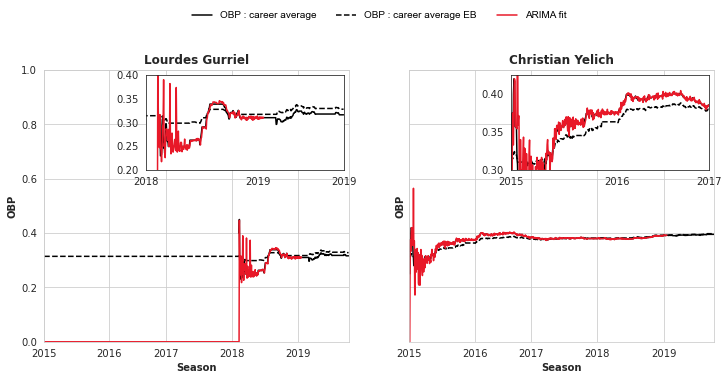

In [217]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pmdarima as pm

# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
    ax = ax.flatten()
    fig.set_size_inches(12,5)

    xtickvalsall = np.array([[2018,2019,2019],[2015,2016,2017]])
    xticksall = np.array((np.concatenate([player_data.loc[player_data.game_date.isin(mlb_dates.loc[xtickvalsall[0][0:2],"Start"].tolist())].index.to_numpy(), player_data.loc[player_data.game_date.isin(mlb_dates.loc[[xtickvalsall[0][-1]],"End"])].index.to_numpy()]),player_data.loc[player_data.game_date.isin(mlb_dates.loc[xtickvalsall[1],"Start"].tolist())].index.to_numpy()))
    xlimvals = np.array([[player_data.loc[player_data.game_date.isin([mlb_dates.loc[2018,"Start"]])].index.item(),player_data.loc[player_data.game_date.isin([mlb_dates.loc[2019,"Start"]])].index.item()],
                        [player_data.loc[player_data.game_date.isin([mlb_dates.loc[2015,"Start"]])].index.item(),player_data.loc[player_data.game_date.isin([mlb_dates.loc[2017,"Start"]])].index.item()]])
    ylimvals = np.array([[.2,.4],[.3,.425]])

    for (name,thisax,xlim,xticks,xtickvals,ylim) in zip(["Lourdes Gurriel","Christian Yelich"],ax,xlimvals,xticksall,xtickvalsall,ylimvals):
        # Get player data
        player_data = sd2.loc[sd2.player_name.isin([name]),:].reset_index(drop=True)

        # Get training data
        mask = (player_data.game_date < "2019-05-01")
        train = player_data.loc[mask,"OBP_expanding_career"].fillna(0).to_numpy()
        test  = player_data.loc[~mask,"OBP_expanding_career"].fillna(0).to_numpy()

        # Fit model
        # fitting a stepwise model:
        model_fit = pm.auto_arima(train, start_p=1, start_q=1, max_p=10, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

        # model = ARIMA(train, order=(10,1,0))
        # model_fit = model.fit()
        

        # Get the index location of the start game dates
        xticks1 = player_data.loc[player_data.game_date.isin(mlb_dates.Start)].index
        # Get index location of data window
        fill_win = player_data.loc[player_data.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
        
        # Plot data - cumulative OBP year by year and career
        # thisax.axvline(x=fill_win[0],color='k',alpha=0.5)
        # thisax.axvline(x=fill_win[-1],color='k',alpha=0.5)
        # thisax.fill_between(x=fill_win,y1=len(fill_win)*[0],y2=len(fill_win)*[1],color='k',alpha=0.1,label="To predict")
        # thisax.plot(player_data.index,player_data.OBP_expanding_year,color=blue,lw=1.5, label="OBP : year by year average")
        # thisax.plot(player_data.index,player_data.OBP_expanding_year_EB,color=blue,linestyle='--',lw=1.5,label="OBP : year by year EB average")
        thisax.plot(player_data.index,player_data.OBP_expanding_career,color='k',lw=1.5,label="OBP : career average")
        thisax.plot(player_data.index,player_data.OBP_expanding_career_EB,color='k',linestyle='--',lw=1.5,label="OBP : career average EB")
        # thisax.plot(player_data.index[mask],model_fit.fittedvalues,color=red,label="ARIMA fit")
        thisax.plot(player_data.index[mask],model_fit.predict_in_sample(),color=red,label="ARIMA fit")

        # Clean up
        thisax.set_ylim(0,1)
        thisax.set_xlim(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
        thisax.set_xticks(xticks1)
        thisax.set_xticklabels(list(map(str,mlb_dates.index)))
        thisax.set_xlabel("Season",fontweight="bold")
        thisax.set_ylabel("OBP",fontweight="bold")
        thisax.set_title(player_data.player_name.unique()[0],fontweight="bold")

        with sns.axes_style("white"):
            # Add inset
            axin = inset_axes(thisax, width="65%", height="35%")

            axin.plot(player_data.index,player_data.OBP_expanding_career,color='k',lw=1.5,label="OBP : career average")
            axin.plot(player_data.index,player_data.OBP_expanding_career_EB,color='k',linestyle='--',lw=1.5,label="OBP : career average EB")
            axin.plot(player_data.index[mask],model_fit.predict_in_sample(),color=red,label="ARIMA fit")
            # axin.plot(player_data.index[mask],model_fit.fittedvalues,color=red,label="ARIMA fit")


            axin.set_xlim(xlim[0],xlim[1])
            axin.set_ylim(ylim[0],ylim[1])
            axin.set_xticks(xticks)
            axin.set_xticklabels(xtickvals)
            
ax[0].legend(ncol=3,loc=9,frameon=False,bbox_to_anchor=(1.1, 1.25))
    

Make a backup copy because some methods cause the object to grow. If something happens there is no way to revert back to the model that was a result of the training. 

In [219]:
import copy
model_train = copy.deepcopy(model_fit)

Test it out...

In [232]:
def test_arima(model,test_data,n_periods,update_with_true=False):
    
    # Max n_periods
    if n_periods > len(test_data):
        n_periods = len(test_data)

    # If predicting full length of data and with no true updates do it in one step
    if (n_periods == len(test_data)) & (update_with_true == False):
        test_predict, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        cf= pd.DataFrame(confint)
    # otherwise, use loop to shift along data
    else: 
        # Loop through based on number of iterations
        predict = []
        cnt = 0
        out = pd.DataFrame({"predict": [], "ci_low": [], "ci_high": []})
        while (cnt+n_periods) < len(test_data):              
                # Make prediction n_periods out
                test_predict, confint = model.predict(n_periods=n_periods, return_conf_int=True)
                # Update model
                if update_with_true:
                    model.update(test_data[cnt:(cnt+n_periods)],maxiter=10)
                else:
                    model_fit.update(test_predict,maxiter=10)
                # Add to dataframe and concat along rows
                out = pd.concat([out,pd.DataFrame({"predict": test_predict, "ci_low": confint[:,0], "ci_high": confint[:,1]})],axis=0)
                # Update count
                cnt += n_periods

    return out.reset_index(drop=True), model

if len(model_fit.predict_in_sample()) != len(train):
    model_fit = copy.deepcopy(model_train)

df, model_fit = test_arima(model_fit,test,20,update_with_true=True)



This is only one player because I didn't save the model in the loop and its slow...

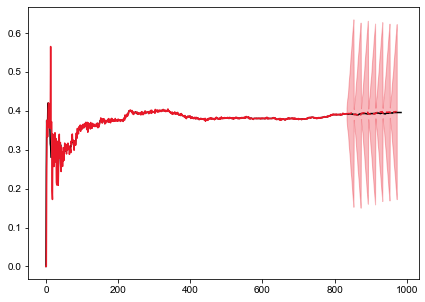

In [244]:

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
xvals = range(len(np.concatenate([train,test])))
xvals2 = range(len(df))
ax.plot(xvals,np.concatenate([train,test]),color='k')
ax.plot(range(len(train)),model_fit.predict_in_sample()[:len(train)],color=red)
ax.plot([x+ len(train) for x in list(xvals2)],df.loc[xvals2,"predict"],color=red,linestyle='--')
ax.fill_between([x+ len(train) for x in list(xvals2)],
                df.loc[xvals2,"ci_low"],
                df.loc[xvals2,"ci_high"],color=red,alpha=.3)

We can see that the error grows as we make predictions further and further out. This one shows predictions 20 timesteps in advance. In our data, this is 20 days, which could include a few games for a player or up to 20 if they have no days off. 


Let's clean the code up and run for multiple players.

In [361]:
##########################
#                        #
#          TRAIN         #
#                        #
##########################
def train_arima(train,test):
    # Fit model
    model_fit = pm.auto_arima(train, start_p=1, start_q=1, max_p=10, max_q=3, m=12,
                            start_P=0, seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

    return model_fit

##########################
#                        #
#          TEST          #
#                        #
##########################
def test_arima(model,test_data,n_periods,update_with_true=False):
    
    # Max n_periods
    if n_periods > len(test_data):
        n_periods = len(test_data)

    out = pd.DataFrame({"predict": [], "ci_low": [], "ci_high": []})
    
    # If predicting full length of data and with no true updates do it in one step
    if (n_periods == len(test_data)) & (update_with_true == False):
        test_predict, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        out = pd.concat([out,pd.DataFrame({"predict": test_predict, "ci_low": confint[:,0], "ci_high": confint[:,1]})],axis=0)
    # otherwise, use loop to shift along data
    else: 
        # Loop through based on number of iterations
        predict = []
        cnt = 0
        while (cnt+n_periods) < len(test_data):              
                # Make prediction n_periods out
                test_predict, confint = model.predict(n_periods=n_periods, return_conf_int=True)
                # Update model
                if update_with_true:
                    model.update(test_data[cnt:(cnt+n_periods)],maxiter=10)
                else:
                    model_fit.update(test_predict,maxiter=10)
                # Add to dataframe and concat along rows
                out = pd.concat([out,pd.DataFrame({"predict": test_predict, "ci_low": confint[:,0], "ci_high": confint[:,1]})],axis=0)
                # Update count
                cnt += n_periods

    return out.reset_index(drop=True), model

def train_test_arima(player_names,n_periods=50,update_with_true=True):
    # Select a few so it doesnt run until eternity
    # which_players = bd.loc[bd.Name.isin(["Bryce Harper"]),"key_mlbam"].tolist() #
    which_players = bd.loc[bd.Name.isin(player_names    ),"key_mlbam"].tolist()

    # For each player
    player_dict = sd2.groupby(by="batter").agg({"player_name": "last"})
    model_dict = pd.DataFrame({"Batter": [name for name in which_players], "Name": [player_dict.loc[name,"player_name"] for name in which_players], "Model": len(which_players)*[0],"Predictions": len(which_players)*[0]})
    allmodels = []
    predictions = []
    for name in which_players:
        # Get player data
        player_data = sd2.loc[sd2.batter.isin([name]),:].reset_index(drop=True)

        # Get training data
        mask = (player_data.game_date < "2019-05-01")
        train = player_data.loc[mask,"OBP_expanding_career"].fillna(0).to_numpy()
        test  = player_data.loc[~mask,"OBP_expanding_career"].fillna(0).to_numpy()

        # Train model
        model_fit = train_arima(train,test)
        # model_dict.loc[model_dict.Batter == name,"Model"] = copy.deepcopy(model_fit)
        allmodels.append(copy.deepcopy(model_fit))

        # Test model
        df, model_fit = test_arima(model_fit,test,n_periods,update_with_true=update_with_true)
        # model_dict.loc[model_dict.Batter == name,"Predictions"] = df.copy() 
        predictions.append(df.copy())

    model_dict = pd.DataFrame({"Batter": [name for name in which_players], "Name": [player_dict.loc[name,"player_name"] for name in which_players], "Model": allmodels,"Predictions": predictions})
    return model_dict

In [359]:
def plot_train_test_arima(which_players,model_dict):
    # Make figure
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
        ax = ax.flatten()
        fig.set_size_inches(10,10)

        for (name,thisax) in zip(which_players,ax):
            
            # Get player data
            player_data = sd2.loc[sd2.batter.isin([name]),:].reset_index(drop=True)

            # Get training data
            mask = (player_data.game_date < "2019-05-01")
            train = player_data.loc[mask,"OBP_expanding_career"].fillna(0).to_numpy()
            test  = player_data.loc[~mask,"OBP_expanding_career"].fillna(0).to_numpy()

            # Get the index location of the start game dates
            xticks1 = player_data.loc[player_data.game_date.isin(mlb_dates.Start)].index
            
            # Get index location of data window
            fill_win = player_data.loc[player_data.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
            
            # Plot prediciton results
            # thisax.plot(player_data.index[mask],model_dict.loc[model_dict.Batter == batter,"Model"], predict_in_sample(),color=red,label="ARIMA fit")
            xvals = range(len(np.concatenate([train,test])))
            xvals2 = range(len(df))
            thisax.plot(xvals,player_data.OBP_expanding_year[xvals],color=blue,lw=1.5, label="OBP : year by year average")
            thisax.plot(xvals,np.concatenate([train,test]),color='k',label="OBP: career average")
            thismodel = copy.deepcopy(model_dict.loc[model_dict.Batter == name,"Model"].item())
            thisax.plot(range(len(train)),thismodel.predict_in_sample()[:len(train)],color=red,label="ARIMA model")
            thisdf = model_dict.loc[model_dict.Batter == name,"Predictions"].item()
            thisax.plot([x+ len(train) for x in list(xvals2)],thisdf.loc[xvals2,"predict"],color=red,linestyle='--',label="ARIMA Forecast")
            thisax.fill_between([x+ len(train) for x in list(xvals2)],
                                thisdf.loc[xvals2,"ci_low"],
                                thisdf.loc[xvals2,"ci_high"],color=red,alpha=.3,label="ARIMA forecast confidence intervals")

            # Clean up
            thisax.set_ylim(0,1)
            thisax.set_xlim(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
            thisax.set_xticks(xticks1)
            thisax.set_xticklabels(list(map(str,mlb_dates.index)))
            thisax.set_xlabel("Season",fontweight="bold")
            thisax.set_ylabel("OBP",fontweight="bold")
            thisax.set_title(player_data.player_name.unique()[0],fontweight="bold")

            with sns.axes_style("white"):
                # Add inset
                axin = inset_axes(thisax,loc=9, width="45%", height="35%")
                
                # Plot prediciton results
                # thisax.plot(player_data.index[mask],model_dict.loc[model_dict.Batter == batter,"Model"], predict_in_sample(),color=red,label="ARIMA fit")
                xvals = range(len(np.concatenate([train,test])))
                xvals2 = range(len(df))
                axin.plot(xvals,player_data.OBP_expanding_year[xvals],color=blue,lw=1.5)
                axin.plot(xvals,np.concatenate([train,test]),color='k')
                thismodel = copy.deepcopy(model_dict.loc[model_dict.Batter == name,"Model"].item())
                axin.plot(range(len(train)),thismodel.predict_in_sample()[:len(train)],color=red)
                thisdf = model_dict.loc[model_dict.Batter == name,"Predictions"].item()
                axin.plot([x+ len(train) for x in list(xvals2)],thisdf.loc[xvals2,"predict"],color=red,linestyle='--')
                axin.fill_between([x+ len(train) for x in list(xvals2)],
                                thisdf.loc[xvals2,"ci_low"],
                                thisdf.loc[xvals2,"ci_high"],color=red,alpha=.3)

                # Clean up
                axin.set_xlim(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2019,"Start"],mlb_dates.loc[2019,"End"]])].index)
                yy = round(player_data.OBP_expanding_career.to_numpy()[-1],1)
                axin.set_ylim(yy-.05,yy+.05)
                axin.set_yticks([yy-.05,yy,yy+.05])
                axin.set_xticks(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2019,"Start"],mlb_dates.loc[2019,"End"]])].index)
                axin.set_xticklabels(["2019 Start", "2019 End"])
                
    ax[0].legend(ncol=3,loc=9,frameon=False,bbox_to_anchor=(1.1, 1.25))


Run a train/test loop for a model that predicts all the way out to the end of 2019 just using the data from end of April.

In [362]:
model_dict = train_test_arima(["Bryce Harper","Rhys Hoskins","J.T. Realmuto","Jean Segura"],n_periods=len(train),update_with_true=False)

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3548.612, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3814.920, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3589.212, Time=0.15 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3907.836, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3868.257, Time=0.79 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4007.666, Time=2.00 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3923.210, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4006.193, Time=1.51 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4006.003, Time=2.58 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3956.519, Time=1.98 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4003.686, Time=1.87 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=-4005.666, Time=3.31 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 30.329 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4576.179, Time=2.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4304.661, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4527.445, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4508.851, Time=1.32 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4577.807, Time=0.66 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4578.578, Time=0.87 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4567.783, Time=1.91 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4567.483, Time=2.26 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4568.344, Time=21.53 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-4533.987, Time=4.67 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-4571.633, Time=8.03 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-4622.861, Time=3.46 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-4589.493, Time=1.45 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-4532.865, Time=3.65 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-4536.917, Time=1.61 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-4531.878, Time=2.21 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-4577.238, Time=5.09 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=-4444.825, Time=1.22 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-4777.434, Time=11.64 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-4766.487, Time=4.28 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-4765.505, Time=14.74 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4768.721, Time=3.05 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-4676.813, Time=2.67 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-4760.213, Time=4.94 sec
 ARIMA(3,1,2)(1,1,0)[12]             : AIC=-4630.804, Time=2.60 sec
 ARIMA(2,1,3)(1,1,0)[12]             : AIC=-4687.951, Time=3.13 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=-4756.850, Time=2.01 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4624.489, Time=1.95 sec
 ARIMA(3,1,3)(1,1,0)[12]             : AIC=-4591.958, Time=2.71 sec
 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=-4774.747, Time=5.23 sec

Best model:  ARIMA(2,1,2)(1,1,0)[12]          
Total fit time: 122.624 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4305.360, Time=2.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4272.984, Time=0.27 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4275.272, Time=0.72 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4285.703, Time=1.61 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4268.984, Time=0.14 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4314.917, Time=2.16 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4273.176, Time=0.56 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4318.129, Time=3.00 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4295.535, Time=5.68 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-4243.227, Time=4.48 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-4296.097, Time=6.59 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-4315.874, Time=5.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-4314.701, Time=4.19 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-4498.649, Time=4.75 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-4385.500, Time=1.24 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4455.134, Time=4.69 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=-4517.683, Time=9.53 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-4492.360, Time=6.01 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=-4384.717, Time=4.27 sec
 ARIMA(3,1,1)(2,1,2)[12]             : AIC=-4705.373, Time=5.91 sec
 ARIMA(3,1,1)(1,1,2)[12]             : AIC=-4791.750, Time=6.91 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=-4650.795, Time=2.68 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=-4816.556, Time=1.89 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=-4708.043, Time=1.98 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4812.244, Time=2.06 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=-4806.713, Time=6.99 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,1,0)[12]             : AIC=-4716.892, Time=0.84 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4722.775, Time=6.52 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=-4739.609, Time=1.84 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=-4626.906, Time=1.34 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=-4398.535, Time=3.12 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-4392.939, Time=1.10 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4409.389, Time=2.17 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=-4795.695, Time=3.56 sec
 ARIMA(4,1,2)(1,1,1)[12]             : AIC=-4741.669, Time=4.72 sec
 ARIMA(3,1,1)(1,1,1)[12] intercept   : AIC=-4803.038, Time=5.03 sec

Best model:  ARIMA(3,1,1)(1,1,1)[12]          
Total fit time: 126.053 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-3108.244, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2927.047, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3050.376, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3114.019, Time=1.91 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3086.889, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3117.737, Time=2.13 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3104.194, Time=0.86 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-3118.438, Time=3.96 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3112.490, Time=3.22 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-3116.684, Time=5.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3114.505, Time=6.44 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2958.957, Time=2.97 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-3141.366, Time=2.43 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-3144.277, Time=1.52 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3116.840, Time=1.64 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-3166.706, Time=3.78 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=7.21 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-3166.611, Time=5.18 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-3066.227, Time=2.83 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-3140.600, Time=4.09 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-3123.899, Time=4.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2948.222, Time=1.38 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=-3128.288, Time=4.11 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-3079.956, Time=3.08 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-3159.374, Time=4.57 sec
 ARIMA(1,1,1)(1,1,2)[12] intercept   : AIC=-3123.620, Time=9.81 sec

Best model:  ARIMA(1,1,1)(1,1,2)[12]          
Total fit time: 84.260 seconds


Now lets see the results...

In [363]:
model_dict

,Batter,Name,Model,Predictions
0,656555,Rhys Hoskins,"ARIMA(2,1,0)(2,1,0)[12]",predict ci_low ci_high 0 0.37309...
1,516416,Jean Segura,"ARIMA(2,1,2)(1,1,0)[12]",predict ci_low ci_high 0 0.34831...
2,547180,Bryce Harper,"ARIMA(3,1,1)(1,1,1)[12]",predict ci_low ci_high 0 0.39992...
3,592663,J. t. Realmuto,"ARIMA(1,1,1)(1,1,2)[12]",predict ci_low ci_high 0 0.33612...


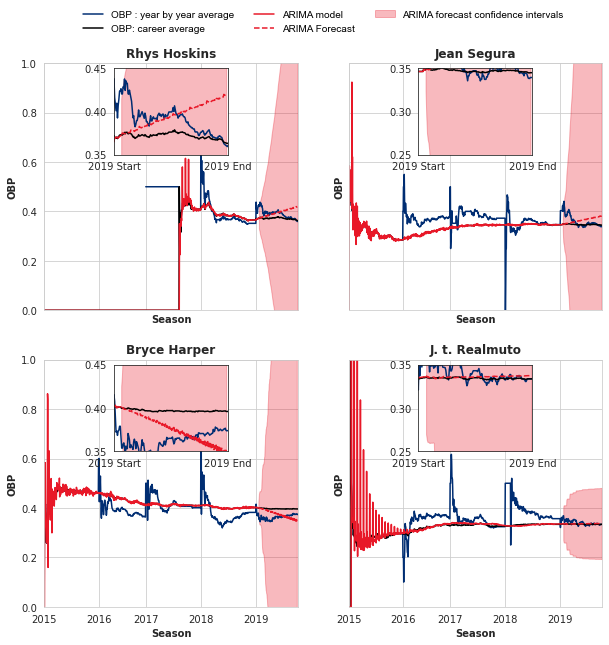

In [364]:
plot_train_test_arima(model_dict.Batter.tolist(),model_dict)

Now lets try it again but we will only predict 10 days out. Also just to see how the confidence is impacted, we will not correct our estimates with real data, but instead we will just use the predictions within future testing of our model.

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3548.612, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3814.920, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3589.212, Time=0.13 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3907.836, Time=0.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3868.257, Time=0.54 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4007.666, Time=1.40 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3923.210, Time=0.30 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.74 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4006.193, Time=1.49 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4006.003, Time=2.49 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3956.519, Time=1.99 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4003.686, Time=1.92 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=-4005.666, Time=3.49 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 29.793 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4576.179, Time=2.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4304.661, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4527.445, Time=1.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4508.851, Time=1.35 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4577.807, Time=0.74 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4578.578, Time=0.92 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4567.783, Time=2.00 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4567.483, Time=2.46 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4568.344, Time=4.69 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-4533.987, Time=0.88 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-4571.633, Time=1.89 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-4622.861, Time=2.72 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-4589.493, Time=1.37 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-4532.865, Time=3.33 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-4536.917, Time=1.48 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-4531.878, Time=1.93 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-4577.238, Time=4.91 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=-4444.825, Time=1.23 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-4777.434, Time=2.92 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-4766.487, Time=0.67 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-4765.505, Time=6.48 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4768.721, Time=3.14 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-4676.813, Time=2.72 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-4760.213, Time=5.12 sec
 ARIMA(3,1,2)(1,1,0)[12]             : AIC=-4630.804, Time=2.71 sec
 ARIMA(2,1,3)(1,1,0)[12]             : AIC=-4687.951, Time=3.41 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=-4756.850, Time=1.99 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4624.489, Time=2.07 sec
 ARIMA(3,1,3)(1,1,0)[12]             : AIC=-4591.958, Time=2.71 sec
 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=-4774.747, Time=5.30 sec

Best model:  ARIMA(2,1,2)(1,1,0)[12]          
Total fit time: 75.034 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4305.360, Time=2.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4272.984, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4275.272, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4285.703, Time=1.71 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4268.984, Time=0.17 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4314.917, Time=2.33 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4273.176, Time=0.58 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4318.129, Time=3.35 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4295.535, Time=6.21 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-4243.227, Time=4.76 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-4296.097, Time=6.96 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-4315.874, Time=5.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-4314.701, Time=4.28 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-4498.649, Time=4.96 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-4385.500, Time=1.32 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4455.134, Time=4.83 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=-4517.683, Time=9.91 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-4492.360, Time=6.21 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=-4384.717, Time=4.03 sec
 ARIMA(3,1,1)(2,1,2)[12]             : AIC=-4705.373, Time=6.16 sec
 ARIMA(3,1,1)(1,1,2)[12]             : AIC=-4791.750, Time=7.15 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=-4650.795, Time=2.81 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=-4816.556, Time=1.88 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=-4708.043, Time=2.02 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4812.244, Time=2.14 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=-4806.713, Time=7.30 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,1,0)[12]             : AIC=-4716.892, Time=0.92 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4722.775, Time=6.79 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=-4739.609, Time=1.83 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=-4626.906, Time=1.28 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=-4398.535, Time=3.19 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-4392.939, Time=1.10 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4409.389, Time=2.30 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=-4795.695, Time=3.71 sec
 ARIMA(4,1,2)(1,1,1)[12]             : AIC=-4741.669, Time=4.89 sec
 ARIMA(3,1,1)(1,1,1)[12] intercept   : AIC=-4803.038, Time=5.18 sec

Best model:  ARIMA(3,1,1)(1,1,1)[12]          
Total fit time: 131.248 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-3108.244, Time=0.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2927.047, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3050.376, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3114.019, Time=1.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3086.889, Time=0.19 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3117.737, Time=2.27 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3104.194, Time=0.89 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-3118.438, Time=4.10 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3112.490, Time=3.52 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-3116.684, Time=5.35 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3114.505, Time=6.74 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2958.957, Time=3.10 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-3141.366, Time=2.59 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-3144.277, Time=1.58 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3116.840, Time=1.67 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-3166.706, Time=3.83 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=7.58 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-3166.611, Time=5.36 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-3066.227, Time=2.99 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-3140.600, Time=4.27 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-3123.899, Time=4.30 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2948.222, Time=1.46 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=-3128.288, Time=4.32 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-3079.956, Time=3.43 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-3159.374, Time=4.77 sec
 ARIMA(1,1,1)(1,1,2)[12] intercept   : AIC=-3123.620, Time=10.01 sec

Best model:  ARIMA(1,1,1)(1,1,2)[12]          
Total fit time: 88.105 seconds


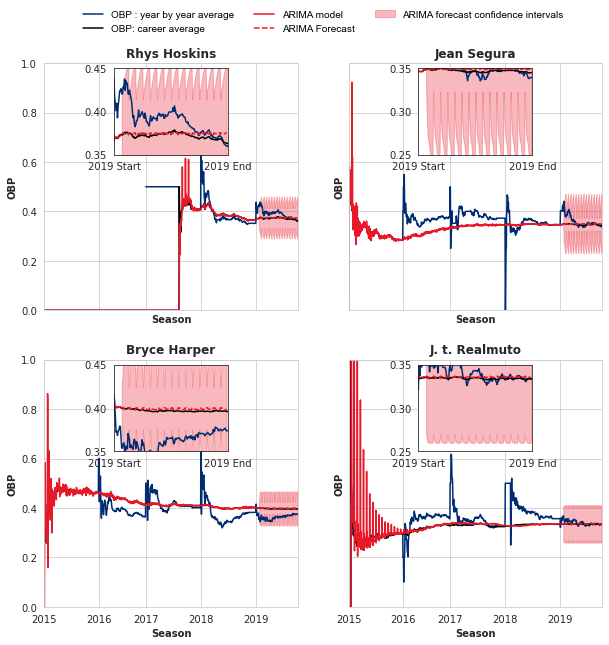

In [365]:
model_dict = train_test_arima(["Bryce Harper","Rhys Hoskins","J.T. Realmuto","Jean Segura"],n_periods=10,update_with_true=False)
plot_train_test_arima(model_dict.Batter.tolist(),model_dict)

Lets try another where to do correct with real data and we do it every ten days. 

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3548.612, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3814.920, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3589.212, Time=0.14 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3907.836, Time=0.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3868.257, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4007.666, Time=1.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3923.210, Time=0.31 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4006.193, Time=1.54 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4006.003, Time=2.58 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3956.519, Time=2.09 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4003.686, Time=1.94 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=-4005.666, Time=3.52 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 30.301 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4576.179, Time=2.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4304.661, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4527.445, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4508.851, Time=1.46 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4577.807, Time=0.77 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4578.578, Time=0.98 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4567.783, Time=2.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4567.483, Time=2.44 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4568.344, Time=4.66 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-4533.987, Time=0.89 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-4571.633, Time=1.93 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-4622.861, Time=2.79 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-4589.493, Time=1.26 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-4532.865, Time=3.52 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-4536.917, Time=1.48 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-4531.878, Time=1.97 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-4577.238, Time=4.81 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=-4444.825, Time=1.21 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-4777.434, Time=3.22 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-4766.487, Time=0.65 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-4765.505, Time=6.37 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4768.721, Time=2.97 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-4676.813, Time=2.77 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-4760.213, Time=5.14 sec
 ARIMA(3,1,2)(1,1,0)[12]             : AIC=-4630.804, Time=2.74 sec
 ARIMA(2,1,3)(1,1,0)[12]             : AIC=-4687.951, Time=3.38 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=-4756.850, Time=2.05 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4624.489, Time=2.10 sec
 ARIMA(3,1,3)(1,1,0)[12]             : AIC=-4591.958, Time=2.89 sec
 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=-4774.747, Time=5.30 sec

Best model:  ARIMA(2,1,2)(1,1,0)[12]          
Total fit time: 75.661 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4305.360, Time=2.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4272.984, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4275.272, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4285.703, Time=1.75 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4268.984, Time=0.15 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4314.917, Time=2.36 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4273.176, Time=0.61 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4318.129, Time=3.38 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4295.535, Time=6.12 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-4243.227, Time=4.71 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-4296.097, Time=6.80 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-4315.874, Time=5.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-4314.701, Time=4.26 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-4498.649, Time=4.92 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-4385.500, Time=1.30 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4455.134, Time=4.84 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=-4517.683, Time=9.97 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-4492.360, Time=6.38 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=-4384.717, Time=4.21 sec
 ARIMA(3,1,1)(2,1,2)[12]             : AIC=-4705.373, Time=6.04 sec
 ARIMA(3,1,1)(1,1,2)[12]             : AIC=-4791.750, Time=7.33 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=-4650.795, Time=2.82 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=-4816.556, Time=2.01 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=-4708.043, Time=2.01 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4812.244, Time=2.23 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=-4806.713, Time=7.28 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,1,0)[12]             : AIC=-4716.892, Time=0.88 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4722.775, Time=6.93 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=-4739.609, Time=1.99 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=-4626.906, Time=1.39 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=-4398.535, Time=3.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-4392.939, Time=1.12 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4409.389, Time=2.25 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=-4795.695, Time=3.76 sec
 ARIMA(4,1,2)(1,1,1)[12]             : AIC=-4741.669, Time=4.98 sec
 ARIMA(3,1,1)(1,1,1)[12] intercept   : AIC=-4803.038, Time=5.28 sec

Best model:  ARIMA(3,1,1)(1,1,1)[12]          
Total fit time: 132.138 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-3108.244, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2927.047, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3050.376, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3114.019, Time=2.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3086.889, Time=0.20 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3117.737, Time=2.44 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3104.194, Time=0.93 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-3118.438, Time=4.09 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3112.490, Time=3.53 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-3116.684, Time=5.61 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3114.505, Time=6.76 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2958.957, Time=3.03 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-3141.366, Time=2.64 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-3144.277, Time=1.64 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3116.840, Time=1.74 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-3166.706, Time=3.97 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=7.58 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-3166.611, Time=5.46 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-3066.227, Time=3.00 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-3140.600, Time=4.30 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-3123.899, Time=4.37 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2948.222, Time=1.48 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=-3128.288, Time=4.57 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-3079.956, Time=3.36 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-3159.374, Time=5.24 sec
 ARIMA(1,1,1)(1,1,2)[12] intercept   : AIC=-3123.620, Time=10.07 sec

Best model:  ARIMA(1,1,1)(1,1,2)[12]          
Total fit time: 89.866 seconds


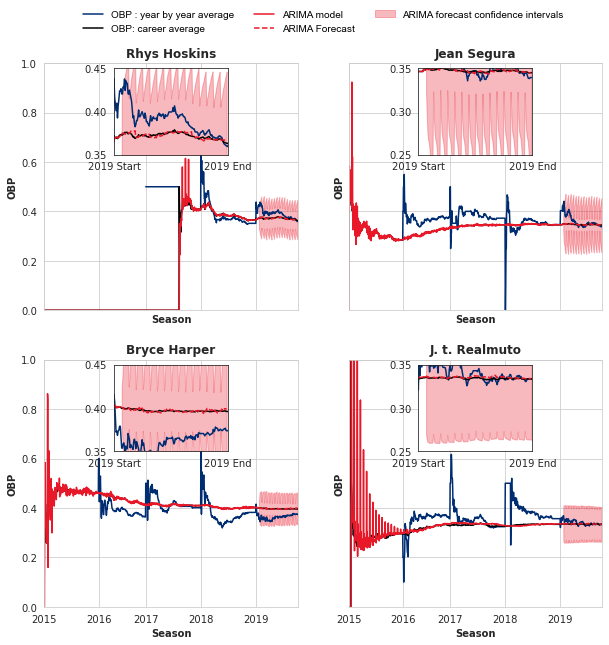

In [366]:
model_dict = train_test_arima(["Bryce Harper","Rhys Hoskins","J.T. Realmuto","Jean Segura"],n_periods=10,update_with_true=True)
plot_train_test_arima(model_dict.Batter.tolist(),model_dict)

Now lets correct on a day-by-day basis.

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3548.612, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3814.920, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3589.212, Time=0.13 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3907.836, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.65 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3868.257, Time=0.50 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4007.666, Time=1.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3923.210, Time=0.29 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4006.193, Time=1.43 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4006.003, Time=2.35 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3956.519, Time=1.88 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4003.686, Time=1.78 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=-4005.666, Time=3.33 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 28.799 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4576.179, Time=2.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4304.661, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4527.445, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4508.851, Time=1.33 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4577.807, Time=0.67 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4578.578, Time=0.94 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4567.783, Time=1.96 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4567.483, Time=2.29 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4568.344, Time=4.48 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-4533.987, Time=0.92 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-4571.633, Time=2.05 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-4622.861, Time=2.77 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-4589.493, Time=1.30 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-4532.865, Time=3.57 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-4536.917, Time=1.59 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-4531.878, Time=1.98 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-4577.238, Time=4.79 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=-4444.825, Time=1.23 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-4777.434, Time=2.96 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-4766.487, Time=0.72 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-4765.505, Time=6.64 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4768.721, Time=3.22 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-4676.813, Time=2.98 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-4760.213, Time=5.65 sec
 ARIMA(3,1,2)(1,1,0)[12]             : AIC=-4630.804, Time=3.16 sec
 ARIMA(2,1,3)(1,1,0)[12]             : AIC=-4687.951, Time=3.53 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=-4756.850, Time=2.06 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4624.489, Time=2.26 sec
 ARIMA(3,1,3)(1,1,0)[12]             : AIC=-4591.958, Time=3.36 sec
 ARIMA(2,1,2)(1,1,0)[12] intercept   : AIC=-4774.747, Time=5.55 sec

Best model:  ARIMA(2,1,2)(1,1,0)[12]          
Total fit time: 77.743 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-4305.360, Time=2.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4272.984, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4275.272, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-4285.703, Time=1.66 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-4268.984, Time=0.15 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-4314.917, Time=2.27 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-4273.176, Time=0.81 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-4318.129, Time=3.60 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4295.535, Time=6.16 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-4243.227, Time=4.59 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-4296.097, Time=6.88 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-4315.874, Time=5.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-4314.701, Time=4.42 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-4498.649, Time=5.20 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-4385.500, Time=1.26 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4455.134, Time=4.74 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=-4517.683, Time=9.66 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-4492.360, Time=6.11 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=-4384.717, Time=4.25 sec
 ARIMA(3,1,1)(2,1,2)[12]             : AIC=-4705.373, Time=6.18 sec
 ARIMA(3,1,1)(1,1,2)[12]             : AIC=-4791.750, Time=7.22 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=-4650.795, Time=2.74 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=-4816.556, Time=1.86 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=-4708.043, Time=1.97 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(1,1,0)[12]             : AIC=-4812.244, Time=2.05 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=-4806.713, Time=7.27 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,1,0)[12]             : AIC=-4716.892, Time=0.89 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=-4722.775, Time=6.86 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=-4739.609, Time=1.87 sec
 ARIMA(4,1,1)(1,1,1)[12]             : AIC=-4626.906, Time=1.29 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=-4398.535, Time=3.16 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-4392.939, Time=1.11 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-4409.389, Time=2.18 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=-4795.695, Time=3.65 sec
 ARIMA(4,1,2)(1,1,1)[12]             : AIC=-4741.669, Time=4.80 sec
 ARIMA(3,1,1)(1,1,1)[12] intercept   : AIC=-4803.038, Time=5.06 sec

Best model:  ARIMA(3,1,1)(1,1,1)[12]          
Total fit time: 130.665 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-3108.244, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2927.047, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3050.376, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3114.019, Time=2.19 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3086.889, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3117.737, Time=2.50 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3104.194, Time=1.03 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-3118.438, Time=4.63 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3112.490, Time=4.07 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-3116.684, Time=5.63 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3114.505, Time=6.90 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2958.957, Time=3.18 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-3141.366, Time=2.60 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-3144.277, Time=1.59 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3116.840, Time=1.72 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-3166.706, Time=3.98 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=7.66 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-3166.611, Time=5.39 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-3066.227, Time=3.24 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-3140.600, Time=4.31 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=-3123.899, Time=4.38 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2948.222, Time=1.51 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=-3128.288, Time=4.35 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-3079.956, Time=3.48 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-3159.374, Time=4.86 sec
 ARIMA(1,1,1)(1,1,2)[12] intercept   : AIC=-3123.620, Time=10.33 sec

Best model:  ARIMA(1,1,1)(1,1,2)[12]          
Total fit time: 91.584 seconds


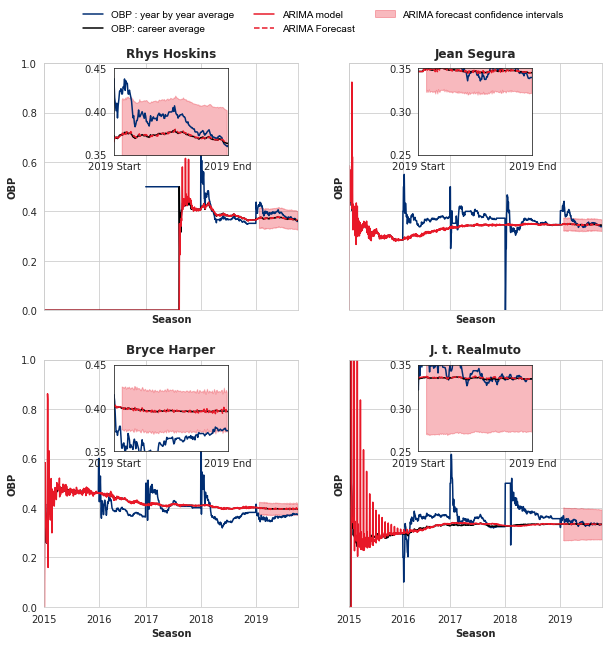

In [367]:
model_dict = train_test_arima(["Bryce Harper","Rhys Hoskins","J.T. Realmuto","Jean Segura"],n_periods=1,update_with_true=True)
plot_train_test_arima(model_dict.Batter.tolist(),model_dict)